In [ ]:
import pandas as pd
from ast import literal_eval
import json
import seaborn as sns
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats


In [40]:
with open('/home/klawren/oak/gtex/data/other_references/gtex_colors.json') as f:
    tissue_df = pd.DataFrame.from_dict(json.load(f), orient='index')
tissue_df = tissue_df.reset_index(names='tissue_name')
tissue_df['tissue_color_hex'] = '#' + tissue_df['tissue_color_hex']
tissue_color_palette = sns.color_palette(tissue_df['tissue_color_hex'])

# get the versions of tissue ids in file names
tissue_df['tissue_file_name'] = (
    tissue_df['tissue_name']
    .str.replace('(', '', regex=False)
    .str.replace(')', '', regex=False)
    .str.replace(' - ', '_')
    .str.replace(' ', '_')
)
tissue_color_map = dict(zip(tissue_df['tissue_file_name'], tissue_df['tissue_color_hex']))

# Load in tissue sample sizes and add tissue_file_name to num_samples
sample_meta = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt', sep='\t')
passed_samples = sample_meta[sample_meta['SMAFRZE'] == 'RNASEQ']
num_samples = pd.DataFrame(passed_samples.groupby('SMTSD').size()).rename(columns={0: 'num_samples'}).reset_index()

# Merge to get tissue_file_name into num_samples
num_samples = pd.merge(
    num_samples,
    tissue_df,
    left_on='SMTSD',
    right_on='tissue_name',
    how='left'
)

gene_type_pal_greyed = {
    'new_lncRNA': '#b70657',         
    'existing_lncRNA': '#d6a5b7',    
    'sRNA': '#b3c6c6',           # lighter/greyer teal
    'pseudogene': '#c2b0c6',     # lighter/greyer purple
    'protein_coding': '#a3b9c6', # lighter/greyer blue
    'artifact': '#cccccc'}        # light grey

qtl_tissue_df = num_samples[num_samples['num_samples'] > 30]

/local/scratch/klawren/slrmtmp.49035793/ipykernel_458/3161590675.py:18: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_meta = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt', sep='\t')


In [3]:
gencode_ids = pd.read_table("/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching.txt")
gencode_ids.head()

/local/scratch/klawren/slrmtmp.49035793/ipykernel_458/668337715.py:1: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  gencode_ids = pd.read_table("/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching.txt")


,gene_id_stable,gene_id_v47,gene_id_v39,gene_type_grouped_highlight,gene_type_v39,gene_type_v47,in_v47_full,in_v47_collapsed,in_v39_full,in_v39_collapsed,collapsed_location_change_v47,collapsed_location_change_v39,collapsed_location_change_between_versions,full_location_change_between_versions
0,ENSG00000000003,ENSG00000000003.16,ENSG00000000003.15,protein_coding,protein_coding,protein_coding,True,True,True,True,False,False,False,False
1,ENSG00000000005,ENSG00000000005.6,ENSG00000000005.6,protein_coding,protein_coding,protein_coding,True,True,True,True,False,False,False,False
2,ENSG00000000419,ENSG00000000419.14,ENSG00000000419.14,protein_coding,protein_coding,protein_coding,True,True,True,True,True,True,True,False
3,ENSG00000000457,ENSG00000000457.14,ENSG00000000457.14,protein_coding,protein_coding,protein_coding,True,True,True,True,False,False,False,False
4,ENSG00000000460,ENSG00000000460.17,ENSG00000000460.17,protein_coding,protein_coding,protein_coding,True,True,True,True,False,False,False,False


In [11]:
# get the medain per tissue tpm
agg_dir = "/home/klawren/oak/gtex/output/all_tissues_quantifications/rnaseqc_agg"
median_expression = []
for tissue in tqdm(qtl_tissue_df['tissue_file_name']):
    expression_file = os.path.join(agg_dir, f"{tissue.replace('-', '_')}.v11.gene_tpm.gct.gz")
    try:
        expression_df = pd.read_table(expression_file, compression='gzip')
    except Exception as e:
        print(f"Error reading {expression_file}: {e}")
        continue
    expression_df.set_index('Name', inplace=True)
    median_expression.append(expression_df[expression_df.columns[3:]].median(axis=1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:14<00:00,  3.89s/it]


In [ ]:
# First, concatenate median_expression into a DataFrame
median_expression_df = pd.concat(median_expression, axis=1)
median_expression_df.columns = qtl_tissue_df['tissue_file_name'].values
median_expression_df = median_expression_df.reset_index()  # 'gene_id' becomes a column

# Merge with gencode_ids on 'gene_id' == 'gene_id_v47'
expression_merged = pd.merge(
    gencode_ids,
    median_expression_df,
    left_on='gene_id_v47',
    right_on='Name',
    how='left'
)

# Fill missing tissue expression values with 0 (skip the gencode ID columns)
expression_cols = qtl_tissue_df['tissue_file_name'].tolist()
expression_merged[expression_cols] = expression_merged[expression_cols].fillna(0)
expression_merged


,gene_id_stable,gene_id_v47,gene_id_v39,gene_type_grouped_highlight,gene_type_v39,gene_type_v47,in_v47_full,in_v47_collapsed,in_v39_full,in_v39_collapsed,...,Skin_Not_Sun_Exposed_Suprapubic,Skin_Sun_Exposed_Lower_leg,Small_Intestine_Terminal_Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole_Blood
0,ENSG00000000003,ENSG00000000003.16,ENSG00000000003.15,protein_coding,protein_coding,protein_coding,True,True,True,True,...,8.287959,9.267488,15.092160,8.651280,10.296851,67.161793,20.005768,29.508517,27.163078,0.105428
1,ENSG00000000005,ENSG00000000005.6,ENSG00000000005.6,protein_coding,protein_coding,protein_coding,True,True,True,True,...,1.682547,3.843514,0.441634,0.180580,0.151731,0.200801,0.311218,0.395748,0.217581,0.000000
2,ENSG00000000419,ENSG00000000419.14,ENSG00000000419.14,protein_coding,protein_coding,protein_coding,True,True,True,True,...,41.866160,41.711531,39.409980,47.959038,34.703914,62.799734,51.377063,60.430171,51.694631,14.158815
3,ENSG00000000457,ENSG00000000457.14,ENSG00000000457.14,protein_coding,protein_coding,protein_coding,True,True,True,True,...,7.591156,8.822668,6.539213,7.089275,5.301707,7.379247,9.662270,9.341283,8.674684,4.353298
4,ENSG00000000460,ENSG00000000460.17,ENSG00000000460.17,protein_coding,protein_coding,protein_coding,True,True,True,True,...,2.273174,2.477519,2.364291,2.822520,1.463214,10.812523,2.972007,4.232007,3.407259,0.948257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79945,ENSG00000310553,ENSG00000310553.1,NaN,new_lncRNA,NaN,lncRNA,True,True,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
79946,ENSG00000310554,ENSG00000310554.1,NaN,new_lncRNA,NaN,lncRNA,True,True,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
79947,ENSG00000310555,ENSG00000310555.1,NaN,new_lncRNA,NaN,lncRNA,True,True,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
79948,ENSG00000310556,ENSG00000310556.1,NaN,new_lncRNA,NaN,lncRNA,True,True,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [90]:
expression_merged

,gene_id_stable,gene_id_v47,gene_id_v39,gene_type_grouped_highlight,gene_type_v39,gene_type_v47,in_v47_full,in_v47_collapsed,in_v39_full,in_v39_collapsed,...,Skin_Not_Sun_Exposed_Suprapubic,Skin_Sun_Exposed_Lower_leg,Small_Intestine_Terminal_Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole_Blood
0,ENSG00000000003,ENSG00000000003.16,ENSG00000000003.15,protein_coding,protein_coding,protein_coding,True,True,True,True,...,8.287959,9.267488,15.092160,8.651280,10.296851,67.161793,20.005768,29.508517,27.163078,0.105428
1,ENSG00000000005,ENSG00000000005.6,ENSG00000000005.6,protein_coding,protein_coding,protein_coding,True,True,True,True,...,1.682547,3.843514,0.441634,0.180580,0.151731,0.200801,0.311218,0.395748,0.217581,0.000000
2,ENSG00000000419,ENSG00000000419.14,ENSG00000000419.14,protein_coding,protein_coding,protein_coding,True,True,True,True,...,41.866160,41.711531,39.409980,47.959038,34.703914,62.799734,51.377063,60.430171,51.694631,14.158815
3,ENSG00000000457,ENSG00000000457.14,ENSG00000000457.14,protein_coding,protein_coding,protein_coding,True,True,True,True,...,7.591156,8.822668,6.539213,7.089275,5.301707,7.379247,9.662270,9.341283,8.674684,4.353298
4,ENSG00000000460,ENSG00000000460.17,ENSG00000000460.17,protein_coding,protein_coding,protein_coding,True,True,True,True,...,2.273174,2.477519,2.364291,2.822520,1.463214,10.812523,2.972007,4.232007,3.407259,0.948257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79945,ENSG00000310553,ENSG00000310553.1,NaN,new_lncRNA,NaN,lncRNA,True,True,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
79946,ENSG00000310554,ENSG00000310554.1,NaN,new_lncRNA,NaN,lncRNA,True,True,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
79947,ENSG00000310555,ENSG00000310555.1,NaN,new_lncRNA,NaN,lncRNA,True,True,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
79948,ENSG00000310556,ENSG00000310556.1,NaN,new_lncRNA,NaN,lncRNA,True,True,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [95]:
new_lncrna_colocs = pd.read_table("/home/klawren/oak/gtex/output/coloc/single_tissue_gwas.lncrna_coloc.txt")
new_lncrna_colocs['gene_ids_list'] = new_lncrna_colocs['gene_ids_list'].apply(literal_eval)
new_lncrna_colocs = pd.merge(new_lncrna_colocs.explode('gene_ids_list'), expression_merged, left_on='gene_ids_list', right_on='gene_id_stable', how='left')
new_lncrna_colocs = new_lncrna_colocs[new_lncrna_colocs['gene_type_grouped_highlight'] == 'new_lncRNA']

In [50]:
lncrna_specific_colocs = pd.read_table("/home/klawren/oak/gtex/output/coloc/single_tissue_gwas.lncrna_specific.txt")
lncrna_specific_colocs['gene_ids_list'] = lncrna_specific_colocs['gene_ids_list'].apply(literal_eval)
lncrna_specific_colocs = lncrna_specific_colocs.explode('gene_ids_list')
print((lncrna_specific_colocs['gene_ids_list'].nunique()))

164


In [97]:
# Melt the dataset so each row is (gene, tissue, expression)
expression_plot_df = expression_merged.melt(
    id_vars=['gene_id_stable', 'gene_type_grouped_highlight'],
    value_vars=qtl_tissue_df['tissue_file_name'].tolist(),
    var_name='Tissue',
    value_name='Expression'
)

# Only keep desired gene types for plot (filtering out possible misc types)
wanted_types = ['new_lncRNA', 'protein_coding']
plot_df = expression_plot_df[expression_plot_df['gene_type_grouped_highlight'].isin(wanted_types)].copy()
plot_df = plot_df[plot_df['Expression'] > 0]


lncrna_specific_coloc_expresssion = pd.merge(lncrna_specific_colocs, expression_plot_df, left_on=['gene_ids_list', 'tissue_id'], right_on=['gene_id_stable', 'Tissue'], how='left')
lncrna_coloc_expresssion = pd.merge(new_lncrna_colocs[['gene_ids_list', 'tissue_id']], expression_plot_df, left_on=['gene_ids_list', 'tissue_id'], right_on=['gene_id_stable', 'Tissue'], how='left')

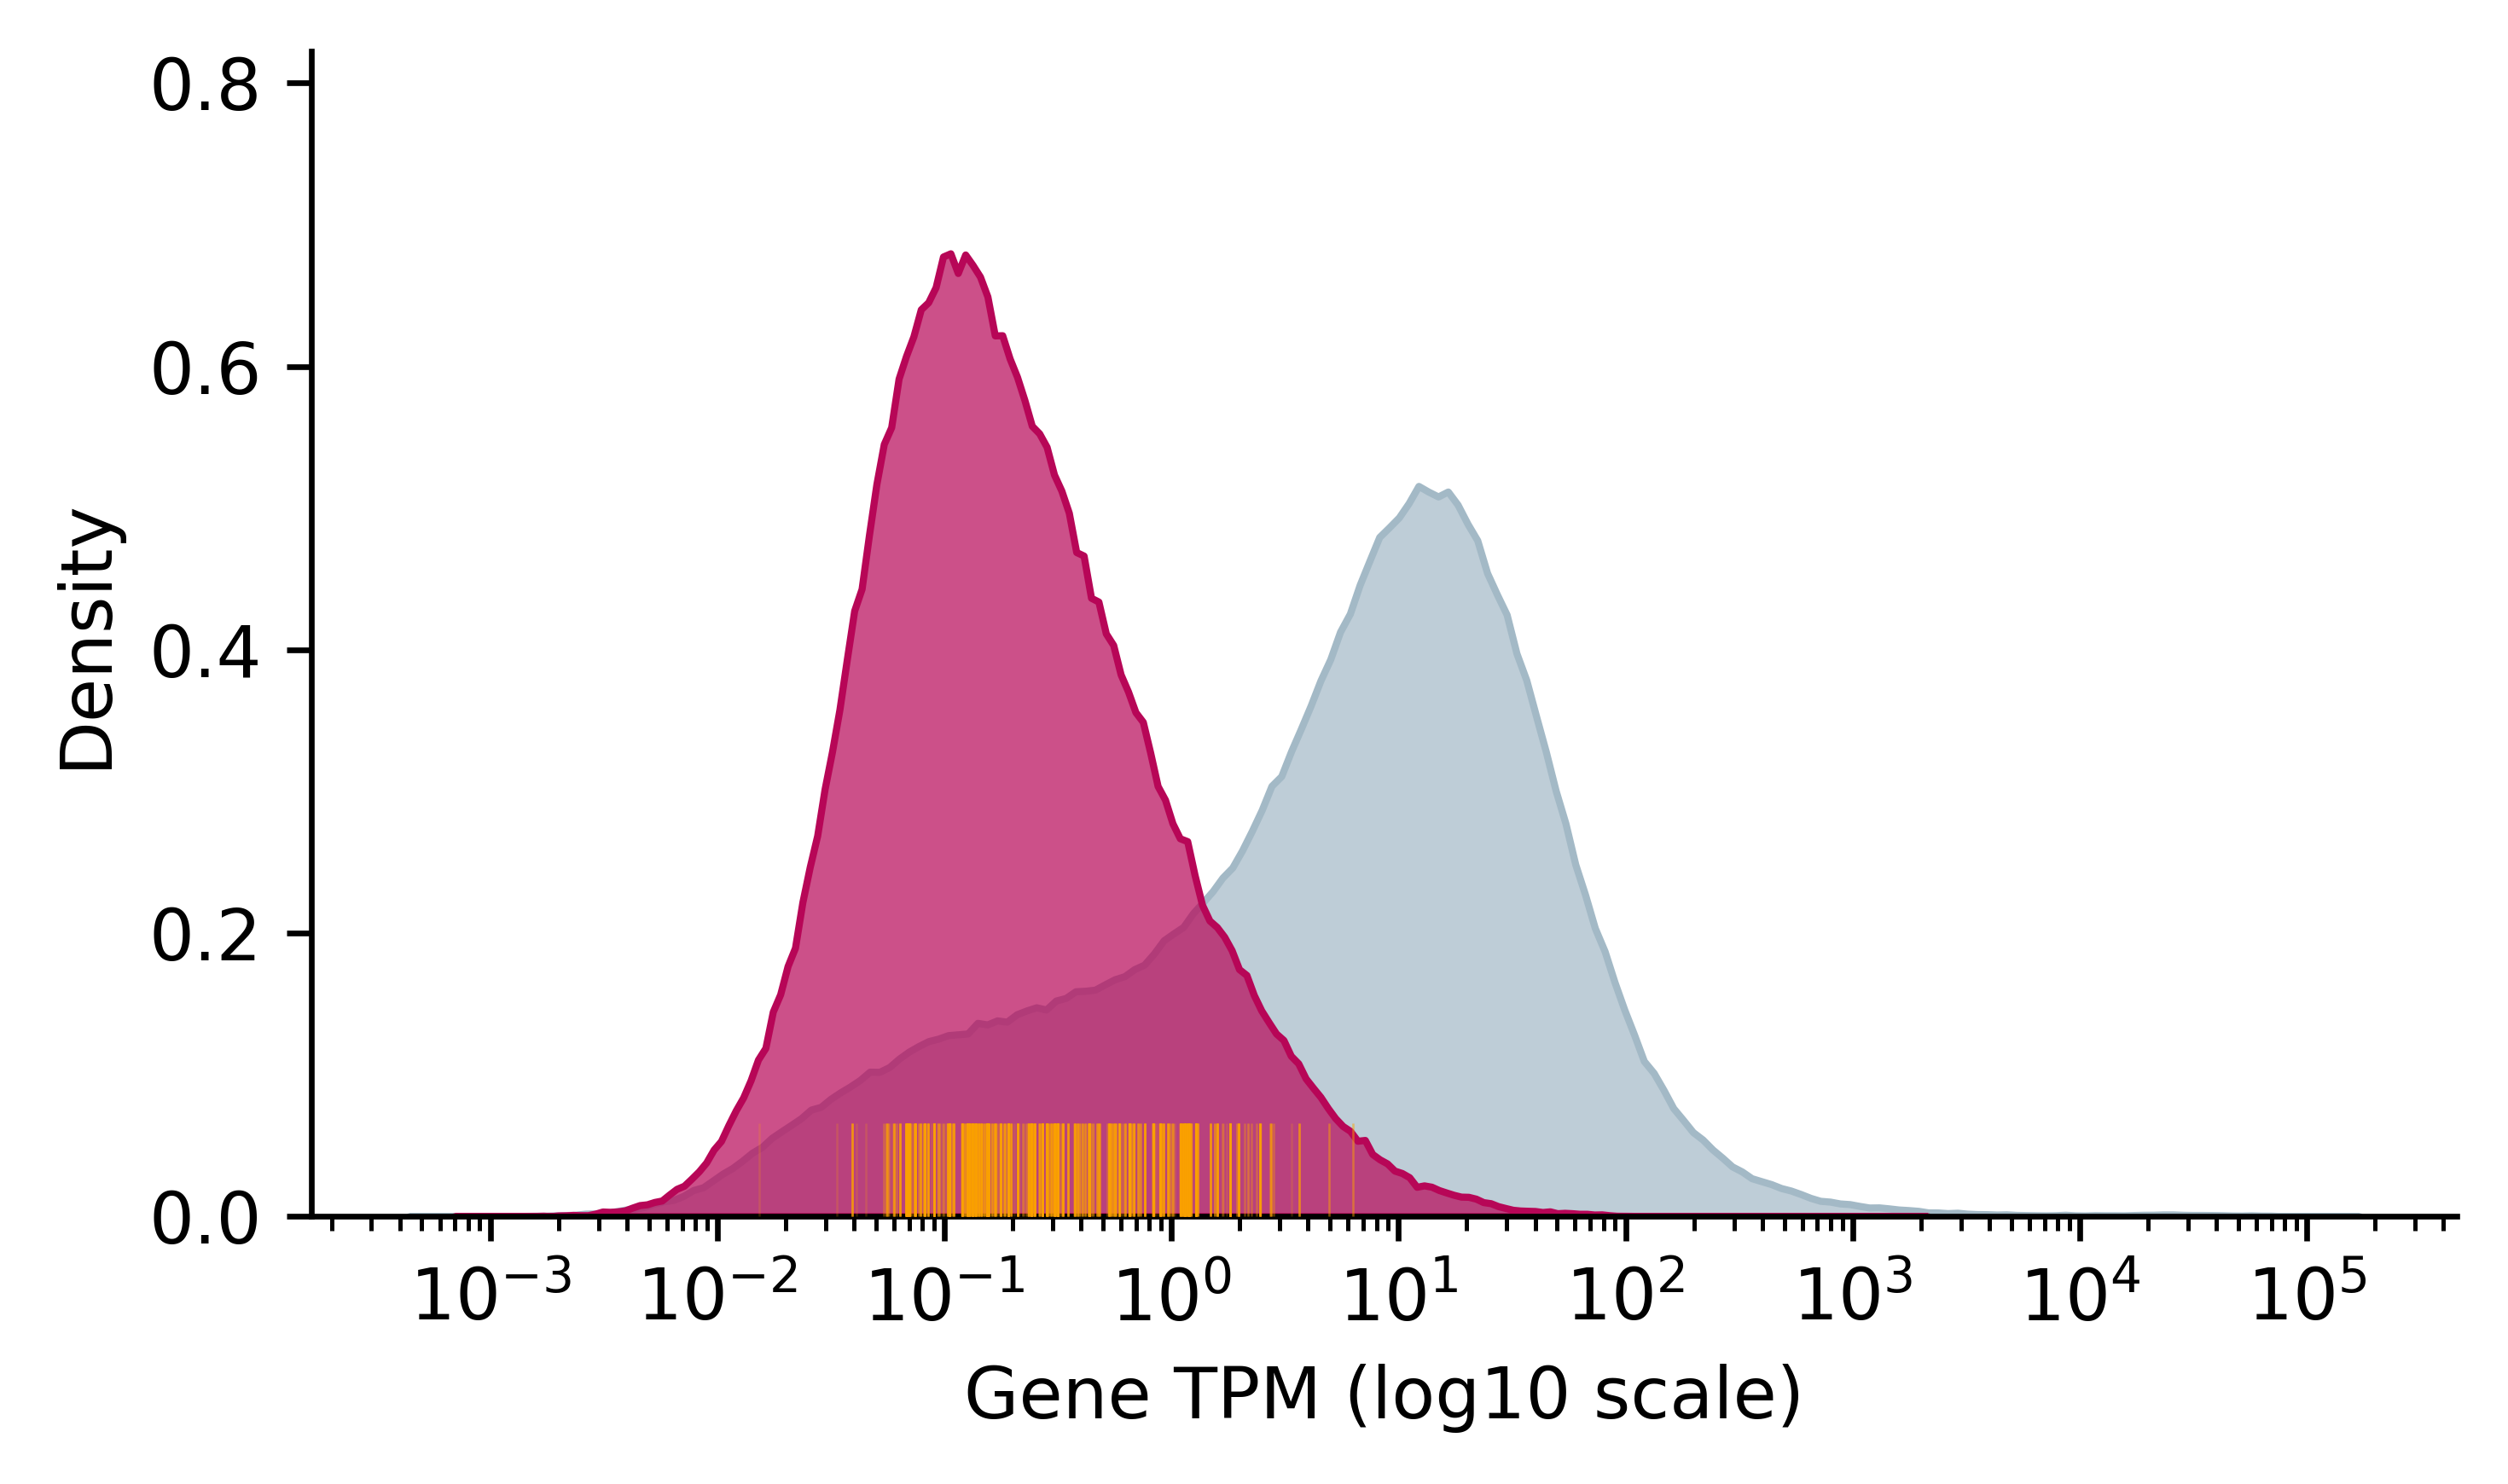

Mann-Whitney U test for lncRNA-specific coloc expr > all new_lncRNA expr:
U=2.8e+08, p=8e-61
Mean lncRNA-specific coloc expr: 0.5350
Mean all new_lncRNA expr: 0.7327


In [ ]:

fig, ax = plt.subplots(figsize=(5, 3), dpi=600)

# Plot KDEs for new_lncRNA and protein_coding only
hue_order = ['new_lncRNA', 'protein_coding']
used_palette = {k: gene_type_pal_greyed[k] for k in hue_order}

sns.kdeplot(
    data=plot_df.sample(1000000),
    x="Expression",
    hue="gene_type_grouped_highlight",
    hue_order=hue_order,
    bw_adjust=0.25,
    log_scale=True,
    fill=True,
    common_norm=False,
    palette=used_palette,
    alpha=0.7,
    ax=ax,
    legend=False
)

# Add rugplot for lncRNA-specific coloc expression values (Expression > 0)
specific_coloc_expr = lncrna_specific_coloc_expresssion.loc[lncrna_specific_coloc_expresssion['Expression'] > 0]
sns.rugplot(
    x=specific_coloc_expr["Expression"],
    ax=ax,
    color="orange",
    alpha=0.2,
    height=0.08, 
    clip_on=False,
    zorder=5,
    linewidth=0.3  
)

ax.set_xlabel("Gene TPM (log10 scale)")
ax.set_ylabel("Density")
sns.despine()
plt.tight_layout()
plt.show()



In [104]:
# ----
# Statistical test: Is lncRNA-specific coloc expression higher than new_lncRNA expression in general?
coloc_expr_vals = specific_coloc_expr["Expression"].values
all_new_lncrna_expr = plot_df.loc[plot_df["gene_type_grouped_highlight"] == "new_lncRNA", "Expression"].values

# (one-sided Mann-Whitney U test, alternative='greater')
stat, pval = stats.mannwhitneyu(coloc_expr_vals, all_new_lncrna_expr, alternative='greater')
print(f"Mann-Whitney U test for lncRNA-specific coloc expr > all new_lncRNA expr:\nU={stat:.2g}, p={pval:.2g}")

# Also print means for context
print(f"Mean lncRNA-specific coloc expr: {coloc_expr_vals.mean():.4f}")
print(f"Mean all new_lncRNA expr: {all_new_lncrna_expr.mean():.4f}")
# Compare lncRNA-specific coloc expression to lncrna_coloc_expresssion (all coloc)
all_coloc_expr_vals = lncrna_coloc_expresssion.loc[lncrna_coloc_expresssion['Expression'] > 0, "Expression"].values

stat2, pval2 = stats.mannwhitneyu(coloc_expr_vals, all_coloc_expr_vals, alternative='greater')
print(f"Mann-Whitney U test for lncRNA-specific coloc expr > all coloc lncRNA expr:\nU={stat2:.2g}, p={pval2:.2g}")

# Means for context
print(f"Mean lncRNA-specific coloc expr: {coloc_expr_vals.mean():.4f}")
print(f"Mean all coloc lncRNA expr: {all_coloc_expr_vals.mean():.4f}")


Mann-Whitney U test for lncRNA-specific coloc expr > all new_lncRNA expr:
U=2.8e+08, p=8e-61
Mean lncRNA-specific coloc expr: 0.5350
Mean all new_lncRNA expr: 0.7327
Mann-Whitney U test for lncRNA-specific coloc expr > all coloc lncRNA expr:
U=1.4e+08, p=1
Mean lncRNA-specific coloc expr: 0.5350
Mean all coloc lncRNA expr: 1.4184
